This main notebook contains the full main pipeline for the cluster analysis presented in the paper. All the other tests and diagnostics performed on the data can be found in `analysis_experiments.ipynb`.

Note: the initial file `sessions.csv` contains the data obtained after eliminating outliers that likely aren't actual session (score < 50 or dartsFired < 10)


# 1 Computing Derived Data

This cell reads the filtered csv file, derives 4 metrics (grip_ratio, input_preference, score_per_throw, throws_per_s), renames movement columns to hand_movement, head_movement, yaw_range, and pitch_range. Finally it saves the data to a new csv file called `sessions_enriched.csv` and displays the first 5 rows.


In [28]:
import pandas as pd
from pathlib import Path

# Loading raw data
df = pd.read_csv('data/sessions.csv')

# calculate derived columns
# input preference metrics
df["grip_ratio"] = df["grip_count"] / (df["grip_count"] + df["trigger_count"])
df["input_preference"] = pd.cut(
    df["grip_ratio"],
    bins=[-float("inf"), 0.30, 0.70, float("inf")],
    labels=["trigger-heavy", "mixed", "grip-heavy"]
)

# performance metrics
df['score_per_throw'] = df['score'] / df['dartsFired']
df['throws_per_s']    = df['dartsFired'] / 180.0 # session length = 180 s
df['controller_path'] = df[['rightControllerMovement', "leftControllerMovement"]].max(axis=1) # rename for brevity

# movement metrics
df = df.rename(
    columns={
        "rightControllerMovement": "hand_movement",
        "headMovement": "head_movement",
        "lookAroundYawRange": "yaw_range",
        "lookAroundPitchRange": "pitch_range",
    }
)

# save the enriched DataFrame to a new CSV file
df.to_csv('data/sessions_enriched.csv', index=False)

print('Derived table saved: sessions_enriched.csv  (rows:', len(df), ')')

# quick preview to display the first 5 rows
df.head(5)


Derived table saved: sessions_enriched.csv  (rows: 151 )


,playerId,timestamp,score,dartsFired,balloonsPopped,head_movement,accuracy,leftControllerMovement,hand_movement,yaw_range,pitch_range,trigger_count,grip_count,grip_ratio,input_preference,score_per_throw,throws_per_s,controller_path
0,2f2b5eaf-497e-49bc-b2eb-0a51dfc2e3c9,2025-05-28T10:41:51.7812250Z,5495,243,182,11.421674,0.748971,1.845922,59.644508,359.779602,42.422947,285,26,0.083601,trigger-heavy,22.613169,1.350000,59.644508
1,d7fc102e-cc55-4e74-bc00-da3775ba5cbe,2025-06-01T10:44:03.2957750Z,450,49,20,3.685956,0.408163,0.019614,14.224772,259.007996,154.145599,71,7,0.089744,trigger-heavy,9.183673,0.272222,14.224772
2,447c0b19-a600-40c3-987f-6fa8c11a6803,2025-06-01T10:44:44.9141340Z,190,29,6,3.419049,0.206897,0.005383,17.287794,358.407959,68.629578,6,35,0.853659,grip-heavy,6.551724,0.161111,17.287794
3,f78e3fdd-31e4-416f-8dba-72615b6650f6,2025-06-01T10:48:49.7221210Z,2400,142,82,15.524384,0.577465,3.099314,48.392853,359.893066,140.702744,6,194,0.970000,grip-heavy,16.901408,0.788889,48.392853
4,073ec056-6872-40c6-b88a-437b268a0e50,2025-06-01T10:49:51.8161690Z,855,35,20,5.223118,0.571429,0.091024,13.797243,250.343506,82.410049,1,46,0.978723,grip-heavy,24.428571,0.194444,13.797243


# 2 Creating the Distance-ready table

This cell loads the previously generate csv file and creates a new DataFrame with winsorized and standardised data. In addition to that, we calculate a DevelopmentIndex to use as a proxy for age. Everything is then added together and saved to `sessions_dist.csv`

In [35]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# loading the enriched data
df_dist = pd.read_csv("data/sessions_enriched.csv")

# selecting numberic features used in PCA and clustering
features = [
    "grip_ratio",
    "accuracy",
    "score_per_throw",
    "throws_per_s",
    "hand_movement",
    "head_movement",
    "yaw_range",
    "pitch_range",
]

# winsorise 1 % tails (per feature)
for col in features:
    lo, hi = np.percentile(df_dist[col], [1, 99])
    df_dist[col] = df_dist[col].clip(lo, hi)

# Z-scale those same colums
df_dist[features] = df_dist[features].apply(zscore)

# compute DevelopmntIndex
df_dist["DevelopmentIndex"] = (
    df_dist["grip_ratio"]      # already z-scaled
    + df_dist["hand_movement"]
    + df_dist["head_movement"]
    - df_dist["accuracy"]
)

# save the distance-ready table
df_dist.to_csv(Path("data/sessions_dist.csv"), index=False)
print("File written: sessions_dist.csv")

df_dist[features + ["DevelopmentIndex"]].describe().T

File written: sessions_dist.csv


,count,mean,std,min,25%,50%,75%,max
grip_ratio,151.0,-1.205805e-16,1.003328,-1.317284,-1.039430,-0.018990,1.116015,1.154275
accuracy,151.0,-1.646953e-16,1.003328,-1.812905,-0.738876,-0.002777,0.556349,2.295103
score_per_throw,151.0,-2.588070e-16,1.003328,-1.664861,-0.759574,-0.078365,0.628460,2.917870
throws_per_s,151.0,2.323381e-16,1.003328,-2.228222,-0.809055,0.197840,0.792463,1.537724
hand_movement,151.0,9.117063e-17,1.003328,-1.724511,-0.719386,-0.090252,0.644136,2.696640
head_movement,151.0,-7.058372e-17,1.003328,-1.462875,-0.729552,-0.232224,0.442250,3.109090
yaw_range,151.0,-9.653794e-16,1.003328,-6.438352,0.191659,0.197578,0.200192,0.202362
pitch_range,151.0,1.117575e-16,1.003328,-2.002879,-0.686853,0.032263,0.879001,1.788916
DevelopmentIndex,151.0,1.176395e-16,2.517209,-5.076376,-1.733764,-0.089454,1.460743,7.194705


# 3 Clustering and PCA

All of the following cells work directly on `sessions_dist.csv` created in Step 2.


## 3.1 Selecting the features for clustering
Loading `sessions_dist.csv`

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# 1. Ergonomic five-feature set
features5 = [
    "grip_ratio",          # input preference
    "accuracy",            # precision
    "score_per_throw",     # efficiency
    "throws_per_s",        # tempo
    "hand_movement",       # gross-motor effort
]

X5 = df_dist[features5].values      # n × 5 matrix for clustering

# 2. Quick silhouette check
sil = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42).fit(X5)
    sil.append(silhouette_score(X5, km.labels_))
best_k = int(np.argmax(sil) + 2)    # +2 because range starts at 2

print(f"Silhouette for k=2..6: {np.round(sil,3)}  →  best k = {best_k}")

Silhouette for k=2..6: [0.234 0.239 0.249 0.229 0.224]  →  best k = 4


## 3.2 PCA scree plot

We plot the eigenvalues and the cumulative variance to decide how many PCs to keep for vizualization.

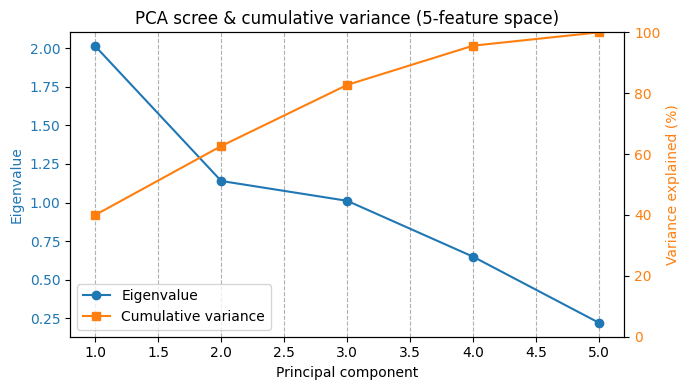

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


pca = PCA().fit(X5)
eig = pca.explained_variance_
cum = np.cumsum(pca.explained_variance_ratio_) * 100

fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(range(1, len(eig)+1), eig, marker="o", label="Eigenvalue")
ax1.set_xlabel("Principal component"); ax1.set_ylabel("Eigenvalue", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue"); ax1.grid(True, axis="x", linestyle="--")

ax2 = ax1.twinx()
ax2.plot(range(1, len(cum)+1), cum, marker="s", linestyle="-",
         color="tab:orange", label="Cumulative variance")
ax2.set_ylabel("Variance explained (%)", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange"); ax2.set_ylim(0, 100)

lines1, labs1 = ax1.get_legend_handles_labels()
lines2, labs2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labs1 + labs2, loc="lower left")
plt.title("PCA scree & cumulative variance (5-feature space)")
plt.tight_layout(); plt.show()

## 3.3 Cluestering with K-Means vs Gaussian Mixture

In [47]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# 1. Reload the distance-ready table (if df_dist not in memory)
df_dist = pd.read_csv(Path("data/sessions_dist.csv"))

# 2. Build the 5-feature matrix used for clustering
features5 = ["grip_ratio", "accuracy", "score_per_throw",
             "throws_per_s", "hand_movement"]
X5 = df_dist[features5].values          # n × 5 numpy array

k_final = 4

# 3. Fit K-means
km  = KMeans(n_clusters=k_final, random_state=42, n_init=10).fit(X5)
sil_km = silhouette_score(X5, km.labels_)

# 4. Fit Gaussian Mixture
gmm = GaussianMixture(n_components=k_final, covariance_type="full",
                      n_init=10, random_state=42).fit(X5)
gmm_labels = gmm.predict(X5)
sil_gmm = silhouette_score(X5, gmm_labels)

# 5. Keep the model with the higher silhouette
if sil_gmm > sil_km:
    df_dist["cluster_id"] = gmm_labels
    chosen_model = "Gaussian Mixture"
    sil_final    = sil_gmm
else:
    df_dist["cluster_id"] = km.labels_
    chosen_model = "K-means"
    sil_final    = sil_km

print(f"Chosen model: {chosen_model}   |   mean silhouette = {sil_final:.3f}")

# 6. Save the cluster-labelled table
out_path = Path("data/sessions_with_clusters.csv")
out_path.parent.mkdir(exist_ok=True)
df_dist.to_csv(out_path, index=False)
print(f"Cluster assignments saved to: {out_path}")

# 7. Quick cluster size overview
print("\nSession count per cluster:")
print(df_dist['cluster_id'].value_counts().sort_index().to_string())

Chosen model: K-means   |   mean silhouette = 0.254
Cluster assignments saved to: data\sessions_with_clusters.csv

Session count per cluster:
cluster_id
0    46
1    43
2    40
3    22


## 3.4 Visualizing clusters: PCA 2D, PCA 3D, t-SNE

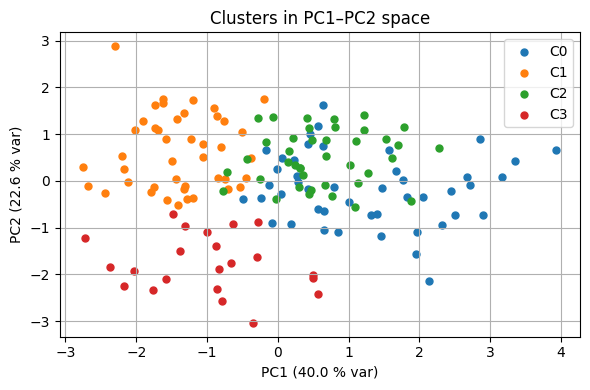

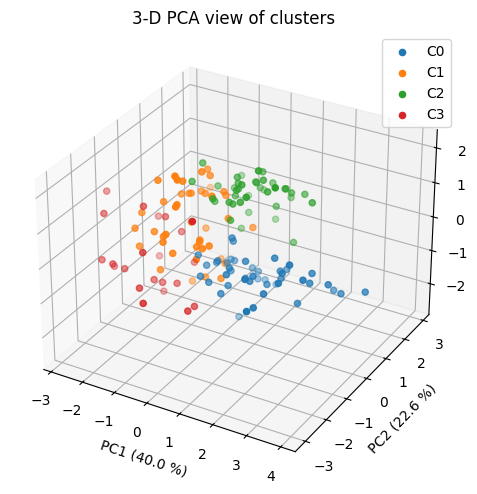

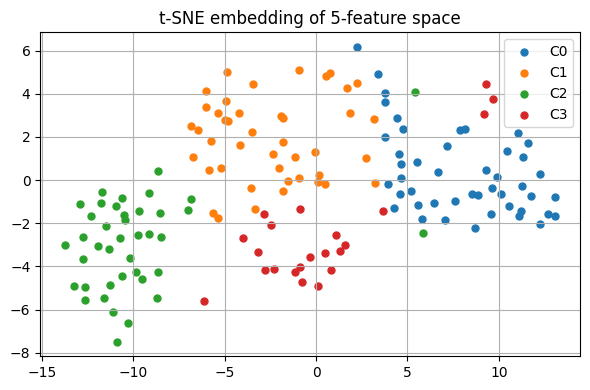

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # registers 3-D projection
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 0. Load cluster-labelled data if not in memory
try:
    df_dist
except NameError:
    df_dist = pd.read_csv("data/sessions_with_clusters.csv")

features5 = ["grip_ratio", "accuracy", "score_per_throw",
             "throws_per_s", "hand_movement"]
X5 = df_dist[features5].values

# 1. PCA (3 comps) for plotting only
pca_vis = PCA(n_components=3, random_state=42).fit(X5)
pcs     = pca_vis.transform(X5)
var_pct = (pca_vis.explained_variance_ratio_ * 100).round(1)   # % variance

# 2-D scatter: PC1 vs PC2
plt.figure(figsize=(6,4))
for c in sorted(df_dist.cluster_id.unique()):
    idx = df_dist.cluster_id == c
    plt.scatter(pcs[idx,0], pcs[idx,1], s=25, label=f"C{c}")
plt.xlabel(f"PC1 ({var_pct[0]} % var)"); plt.ylabel(f"PC2 ({var_pct[1]} % var)")
plt.title("Clusters in PC1–PC2 space")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# 3-D scatter: PC1, PC2, PC3 
fig = plt.figure(figsize=(6,5))
ax  = fig.add_subplot(111, projection="3d")
for c in sorted(df_dist.cluster_id.unique()):
    idx = df_dist.cluster_id == c
    ax.scatter(pcs[idx,0], pcs[idx,1], pcs[idx,2], s=20, label=f"C{c}")
ax.set_xlabel(f"PC1 ({var_pct[0]} %)")
ax.set_ylabel(f"PC2 ({var_pct[1]} %)")
ax.set_zlabel(f"PC3 ({var_pct[2]} %)")
ax.set_title("3-D PCA view of clusters"); ax.legend(); plt.tight_layout(); plt.show()

# 2. t-SNE embedding (2-D) to show local neighbourhoods
tsne = TSNE(n_components=2, perplexity=28, init="pca",
            learning_rate="auto", random_state=42)
ts2  = tsne.fit_transform(X5)

plt.figure(figsize=(6,4))
for c in sorted(df_dist.cluster_id.unique()):
    idx = df_dist.cluster_id == c
    plt.scatter(ts2[idx,0], ts2[idx,1], s=25, label=f"C{c}")
plt.title("t-SNE embedding of 5-feature space")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

## 3.5 Descriptive cluster centroid profiles

In [9]:
import pandas as pd
from pathlib import Path

metrics = features5 + ["score"] # five clustering features + raw score

# 1. aggregate mean ± SD
profile = (df_dist
           .groupby("cluster_id")[metrics]
           .agg(["mean", "std"])
           .round(2))

# 2. add session counts as the **first** column
profile.insert(
    loc = 0,
    column = "n_sessions",
    value = df_dist["cluster_id"].value_counts().sort_index()
)

# 3. flatten the MultiIndex so every column has a simple name
profile.columns = [
    f"{a}_{b}" if isinstance(a, str) and b else a
    if isinstance(a, str) else
    f"{a}_{b}"
    for a, b in profile.columns
]

# 4. save & display
from pathlib import Path
out_path = Path("data/cluster_profiles.csv")
out_path.parent.mkdir(exist_ok=True)
profile.to_csv(out_path, index=True)
print(f"✔  profile saved to: {out_path}")

display(profile)

✔  profile saved to: data\cluster_profiles.csv


,n_sessions,grip_ratio_mean,grip_ratio_std,accuracy_mean,accuracy_std,score_per_throw_mean,score_per_throw_std,throws_per_s_mean,throws_per_s_std,hand_movement_mean,hand_movement_std,score_mean,score_std
cluster_id,,,,,,,,,,,,,
0,46,-1.11,0.21,0.71,0.89,0.59,0.94,0.44,0.76,0.09,0.91,3545.22,1771.56
1,43,0.39,0.79,-0.98,0.53,-0.87,0.51,-0.23,0.79,0.70,0.89,1108.84,614.13
2,40,1.01,0.31,0.43,0.61,0.57,0.74,0.60,0.61,-0.24,0.79,3658.88,1095.37
3,22,-0.29,0.80,-0.34,0.85,-0.55,0.69,-1.55,0.53,-1.12,0.50,632.95,464.80


# 4. Statistical comparison

Tests whether clusters differ on score, accuracy, tempo, etc. Uses Kruskal-Wallis H and p for each metric and Dunn-Holm pair-wise p-value matrices

In [48]:
import scipy.stats as ss, scikit_posthocs as sp, pandas as pd

# select metrics to test
metrics_to_test = ["score","accuracy","score_per_throw","throws_per_s","grip_ratio","hand_movement"]

results = []

if (not Path("data/dunn").exists()):
    Path("data/dunn").mkdir(parents=True)

# 4.2 Kruskal–Wallis + Dunn contrasts for each metric
for m in metrics_to_test:
    groups = [df_dist.loc[df_dist.cluster_id==c, m] 
              for c in sorted(df_dist.cluster_id.unique())]
    H, p = ss.kruskal(*groups)
    results.append([m, H, len(groups)-1, p])
    if p < 0.05:          # save Dunn matrix for significant metrics
        sp.posthoc_dunn(df_dist, val_col=m, group_col="cluster_id",
                        p_adjust="holm").round(4).to_csv(f"data/dunn/dunn_{m}.csv")

results_df = pd.DataFrame(results, columns=["metric", "H", "df", "p"]).round(3)

print("\nKruskal–Wallis test results:")
print(results_df)

#pd.DataFrame(results, columns=["metric","H","df","p"]).round(3).to_csv("data/kruskal_results.csv", index=False)


Kruskal–Wallis test results:
            metric        H  df    p
0            score  103.926   3  0.0
1         accuracy   79.647   3  0.0
2  score_per_throw   78.103   3  0.0
3     throws_per_s   67.160   3  0.0
4       grip_ratio   98.901   3  0.0
5    hand_movement   55.359   3  0.0


# 5. Robustness & sensitivity

Show that clusters are stable to noise and hyper-parameters. Adjusted Rand Index under 5% noise. Sillhouette for k = 3 and k = 5.

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
import numpy as np

def rand_index_noise(X, labels, runs=10, noise=0.05):
    ari = []
    for _ in range(runs):
        Xn = X * (1 + np.random.uniform(-noise, noise, X.shape))
        ari.append(adjusted_rand_score(labels,
                    KMeans(4, random_state=0).fit_predict(Xn)))
    return np.mean(ari), np.min(ari)

mean_ari, min_ari = rand_index_noise(X5, df_dist.cluster_id.values)
print(f"Mean ARI = {mean_ari:.3f}   |   min ARI = {min_ari:.3f}")

# 5.2 Silhouette for k = 3 and k = 5
for k in (3, 5):
    s = silhouette_score(X5, KMeans(k, random_state=42).fit_predict(X5))
    print(f"Silhouette k={k}: {s:.3f}")

Mean ARI = 0.706   |   min ARI = 0.546
Silhouette k=3: 0.239
Silhouette k=5: 0.229
